# Replicating Contract Charts

This notebook creates the plots for Figures 6, 7, and 8.

In [1]:
import os
import sys
import re

from itertools import *
from operator import mul
from functools import reduce
import pickle

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

idx = pd.IndexSlice

from research_tools import storage

pd.options.display.float_format = lambda x: '{:,.4f}'.format(x) if abs(x) < 1 else '{:,.2f}'.format(x)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#555555', label='Yes Contracts', markersize=10),
    Line2D([0], [0], marker='X', color='w', markerfacecolor='#555555', label='No Contracts', markersize=10)
]

# Load Data

In [2]:
os.chdir('..')

basename = 'dem'

dem_replicating_contracts, = storage.retrieve_all([basename + '.replicating_contracts'])

basename = 'gop'

rep_replicating_contracts, = storage.retrieve_all([basename + '.replicating_contracts'])

Reading data from data/dem.replicating_contracts.p
Reading data from data/gop.replicating_contracts.p


In [3]:
dem_replicating_contracts.keys()

dict_keys(['no contracts spreads but no fees', 'yes contracts spreads and fees', 'yes contracts spreads but no fees', 'no contracts no spreads or fees', 'no contracts spreads and fees', 'yes contracts no spreads or fees'])

In [4]:
dem_trader_analysis1_yes = dem_replicating_contracts['yes contracts no spreads or fees']
dem_trader_analysis1_no = dem_replicating_contracts['no contracts no spreads or fees']

rep_trader_analysis1_yes = rep_replicating_contracts['yes contracts no spreads or fees']
rep_trader_analysis1_no = rep_replicating_contracts['no contracts no spreads or fees']

dem_trader_analysis2_yes = dem_replicating_contracts['yes contracts spreads but no fees']
dem_trader_analysis2_no = dem_replicating_contracts['no contracts spreads but no fees']

rep_trader_analysis2_yes = rep_replicating_contracts['yes contracts spreads but no fees']
rep_trader_analysis2_no = rep_replicating_contracts['no contracts spreads but no fees']

dem_trader_analysis3_yes = dem_replicating_contracts['yes contracts spreads and fees']
dem_trader_analysis3_no = dem_replicating_contracts['no contracts spreads and fees']

rep_trader_analysis3_yes = rep_replicating_contracts['yes contracts spreads and fees']
rep_trader_analysis3_no = rep_replicating_contracts['no contracts spreads and fees']

#  Limits

As explained in the paper, we will remove datapoints from the charts for two reasons:

1. trades that took place before the margin linking cutoff dates

The majority of the trading volume took place after margin linking was added to these markets. Margin linking caused significant changes to market pricing, so mixing the data from that period with the rest of the data is not helpful. A separate notebook shows the data from the pre-margin linking period.

2. trades where the replication portfolio requires trading too many shares of a single contract

For a very small number of trades, the replication portfolio requires trading an excessive number of shares of another contract. This makes it unrealistic that a trader could have traded the alternative instead. This is only relevant for the No contract trades.

In [5]:
rep_margin_linking_cutoff_date = '2015-12-01'
dem_margin_linking_cutoff_date = '2015-10-22'

replication_share_qty_cutoff = 10

In [6]:
# only use trades after the dem margin linking cutoff date
dem_trader_analysis1_yes = dem_trader_analysis1_yes[
    dem_trader_analysis1_yes.loc[idx[:, ('_trades', 'date_executed')]] > dem_margin_linking_cutoff_date]
dem_trader_analysis1_no = dem_trader_analysis1_no[
    dem_trader_analysis1_no.loc[idx[:, ('_trades', 'date_executed')]] > dem_margin_linking_cutoff_date]

dem_trader_analysis2_yes = dem_trader_analysis2_yes[
    dem_trader_analysis2_yes.loc[idx[:, ('_trades', 'date_executed')]] > dem_margin_linking_cutoff_date]
dem_trader_analysis2_no = dem_trader_analysis2_no[
    dem_trader_analysis2_no.loc[idx[:, ('_trades', 'date_executed')]] > dem_margin_linking_cutoff_date]

dem_trader_analysis3_yes = dem_trader_analysis3_yes[
    dem_trader_analysis3_yes.loc[idx[:, ('_trades', 'date_executed')]] > dem_margin_linking_cutoff_date]
dem_trader_analysis3_no = dem_trader_analysis3_no[
    dem_trader_analysis3_no.loc[idx[:, ('_trades', 'date_executed')]] > dem_margin_linking_cutoff_date]

# only use trades after the rep margin linking cutoff date
rep_trader_analysis1_yes = rep_trader_analysis1_yes[
    rep_trader_analysis1_yes.loc[idx[:, ('_trades', 'date_executed')]] > rep_margin_linking_cutoff_date]
rep_trader_analysis1_no = rep_trader_analysis1_no[
    rep_trader_analysis1_no.loc[idx[:, ('_trades', 'date_executed')]] > rep_margin_linking_cutoff_date]

rep_trader_analysis2_yes = rep_trader_analysis2_yes[
    rep_trader_analysis2_yes.loc[idx[:, ('_trades', 'date_executed')]] > rep_margin_linking_cutoff_date]
rep_trader_analysis2_no = rep_trader_analysis2_no[
    rep_trader_analysis2_no.loc[idx[:, ('_trades', 'date_executed')]] > rep_margin_linking_cutoff_date]

rep_trader_analysis3_yes = rep_trader_analysis3_yes[
    rep_trader_analysis3_yes.loc[idx[:, ('_trades', 'date_executed')]] > rep_margin_linking_cutoff_date]
rep_trader_analysis3_no = rep_trader_analysis3_no[
    rep_trader_analysis3_no.loc[idx[:, ('_trades', 'date_executed')]] > rep_margin_linking_cutoff_date]

In [7]:
dem_trader_analysis1_no = dem_trader_analysis1_no[
    dem_trader_analysis1_no[('replication', 'd')].abs() < replication_share_qty_cutoff]

dem_trader_analysis2_no = dem_trader_analysis2_no[
    dem_trader_analysis2_no[('replication', 'd')].abs() < replication_share_qty_cutoff]

rep_trader_analysis1_no = rep_trader_analysis1_no[
    rep_trader_analysis1_no[('replication', 'd')].abs() < replication_share_qty_cutoff]

rep_trader_analysis2_no = rep_trader_analysis2_no[
    rep_trader_analysis2_no[('replication', 'd')].abs() < replication_share_qty_cutoff]

def get_max_value(d_dict):
    try:
        d_dict = eval(d_dict)
        d_dict.pop('contracts')
        return max(d_dict.values())
    except:
        return np.nan

dem_trader_analysis3_no = dem_trader_analysis3_no[
    dem_trader_analysis3_no[('replication', 'd')].apply(get_max_value) < replication_share_qty_cutoff]

rep_trader_analysis3_no = rep_trader_analysis3_no[
    rep_trader_analysis3_no[('replication', 'd')].apply(get_max_value) < replication_share_qty_cutoff]

# No Spreads or Fees

The next two charts are for Figure 6.

In [8]:
!mkdir -p charts

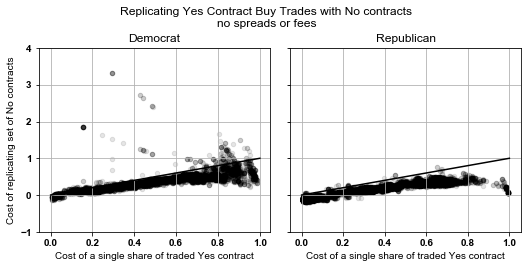

In [9]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

fig = plt.figure(figsize=(7.5, 3.75))

ax1 = plt.subplot(121)

dem_trader_analysis1_yes.plot.scatter(x=('replication', 'Y_a'),
                                      y=('replication', 'max_loss'),
                                      alpha=0.1, ax=ax1, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.suptitle("Replicating Yes Contract Buy Trades with No contracts\nno spreads or fees")
plt.title("Democrat")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax2 = plt.subplot(122)

rep_trader_analysis1_yes.plot.scatter(x=('replication', 'Y_a'),
                                      y=('replication', 'max_loss'),
                                      alpha=0.1, ax=ax2, sharey=ax1, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.92))

plt.savefig('charts/all_yes_no_spread_no_fees.png', dpi=300)

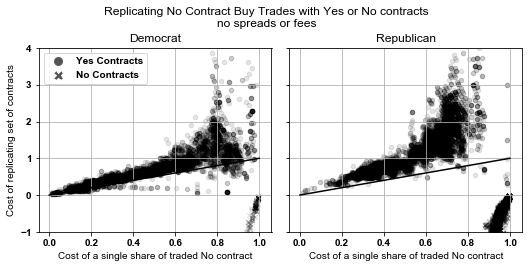

In [10]:
fig = plt.figure(figsize=(7.5, 3.75))

ax1 = plt.subplot(121)

dem_trader_analysis1_no[dem_trader_analysis1_no[('replication', 'd')] > 0].plot.scatter(
    x=('replication', 'N_a'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax1, color='k')
dem_trader_analysis1_no[dem_trader_analysis1_no[('replication', 'd')] < 0].plot.scatter(
    x=('replication', 'N_a'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax1, color='k')

plt.ylim([-1, 4])

plt.suptitle("Replicating No Contract Buy Trades with Yes or No contracts\nno spreads or fees")
plt.title("Democrat")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.plot([0, 1], [0, 1], c='k')
plt.legend(handles=legend_elements)
plt.grid(True)

ax2 = plt.subplot(122)

rep_trader_analysis1_no[rep_trader_analysis1_no[('replication', 'd')] > 0].plot.scatter(
     x=('replication', 'N_a'),
     y=('replication', 'max_loss'),
     alpha=0.1, ax=ax2, sharey=ax1, color='k')
rep_trader_analysis1_no[rep_trader_analysis1_no[('replication', 'd')] < 0].plot.scatter(
     x=('replication', 'N_a'),
     y=('replication', 'max_loss'),
     marker='x',
     alpha=0.1, ax=ax2, sharey=ax1, color='k')

plt.ylim([-1, 4])

plt.title("Republican")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.plot([0, 1], [0, 1], c='k')
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.92))

plt.savefig('charts/all_no_no_spread_no_fees.png', dpi=300)

# Spread but no Fees

In [11]:
dem_trader_analysis2_yes_take = dem_trader_analysis2_yes[
    dem_trader_analysis2_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

dem_trader_analysis2_yes_provide = dem_trader_analysis2_yes[
    dem_trader_analysis2_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

rep_trader_analysis2_yes_take = rep_trader_analysis2_yes[
    rep_trader_analysis2_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

rep_trader_analysis2_yes_provide = rep_trader_analysis2_yes[
    rep_trader_analysis2_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

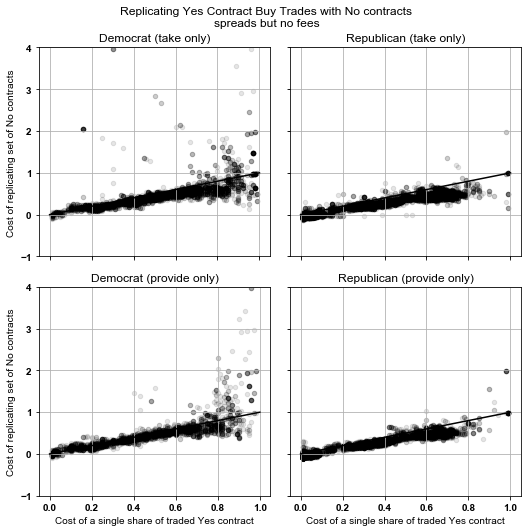

In [12]:
fig = plt.figure(figsize=(7.5, 7.5))

ax3 = plt.subplot(223)

dem_trader_analysis2_yes_provide.plot.scatter(x=('_trades', 'price_per_share'),
                                              y=('replication', 'max_loss'),
                                              alpha=0.1, ax=ax3, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.suptitle("Replicating Yes Contract Buy Trades with No contracts\nspreads but no fees")
plt.title("Democrat (provide only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax4 = plt.subplot(224)

rep_trader_analysis2_yes_provide.plot.scatter(x=('_trades', 'price_per_share'),
                                              y=('replication', 'max_loss'),
                                              alpha=0.1, ax=ax4, sharey=ax3, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (provide only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax1 = plt.subplot(221)

dem_trader_analysis2_yes_take.plot.scatter(x=('_trades', 'price_per_share'),
                                           y=('replication', 'max_loss'),
                                           alpha=0.1, ax=ax1, sharex=ax3, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Democrat (take only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax2 = plt.subplot(222)

rep_trader_analysis2_yes_take.plot.scatter(x=('_trades', 'price_per_share'),
                                           y=('replication', 'max_loss'),
                                           alpha=0.1, ax=ax2, sharey=ax1, sharex=ax4, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (take only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# plt.savefig('charts/all_yes_yes_spread_no_fees.pdf')

In [13]:
dem_trader_analysis2_no_take = dem_trader_analysis2_no[
    dem_trader_analysis2_no.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

dem_trader_analysis2_no_provide = dem_trader_analysis2_no[
    dem_trader_analysis2_no.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

rep_trader_analysis2_no_take = rep_trader_analysis2_no[
    rep_trader_analysis2_no.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

rep_trader_analysis2_no_provide = rep_trader_analysis2_no[
    rep_trader_analysis2_no.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

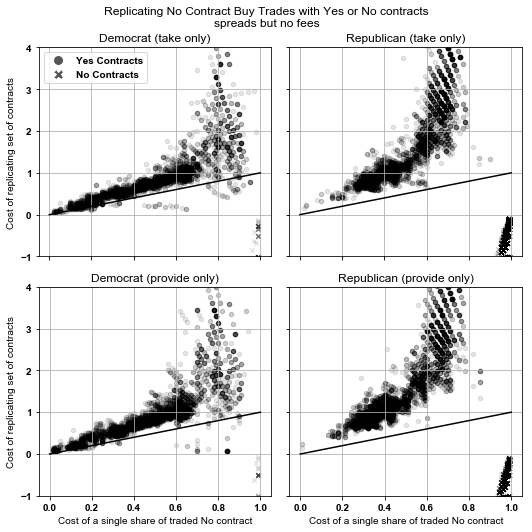

In [14]:
fig = plt.figure(figsize=(7.5, 7.5))

ax3 = plt.subplot(223)

dem_trader_analysis2_no_provide[dem_trader_analysis2_no_provide[('replication', 'd')] > 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax3, color='k')
dem_trader_analysis2_no_provide[dem_trader_analysis2_no_provide[('replication', 'd')] < 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax3, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.suptitle("Replicating No Contract Buy Trades with Yes or No contracts\nspreads but no fees")
plt.title("Democrat (provide only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.grid(True)

ax4 = plt.subplot(224)

rep_trader_analysis2_no_provide[rep_trader_analysis2_no_provide[('replication', 'd')] > 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax4, sharey=ax3, color='k')
rep_trader_analysis2_no_provide[rep_trader_analysis2_no_provide[('replication', 'd')] < 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax4, sharey=ax3, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (provide only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.grid(True)

ax1 = plt.subplot(221)

dem_trader_analysis2_no_take[dem_trader_analysis2_no_take[('replication', 'd')] > 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax1, sharex=ax3, color='k')
dem_trader_analysis2_no_take[dem_trader_analysis2_no_take[('replication', 'd')] < 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax1, sharex=ax3, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Democrat (take only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.legend(handles=legend_elements)
plt.grid(True)

ax2 = plt.subplot(222)

rep_trader_analysis2_no_take[rep_trader_analysis2_no_take[('replication', 'd')] > 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax2, sharey=ax1, sharex=ax4, color='k')
rep_trader_analysis2_no_take[rep_trader_analysis2_no_take[('replication', 'd')] < 0].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax2, sharey=ax1, sharex=ax4, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (take only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# plt.savefig('charts/all_no_yes_spread_no_fees.pdf')

# Spreads and Fees

The next chart is for Figure 7.

In [15]:
dem_trader_analysis3_yes_take = dem_trader_analysis3_yes[
    dem_trader_analysis3_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

dem_trader_analysis3_yes_provide = dem_trader_analysis3_yes[
    dem_trader_analysis3_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

rep_trader_analysis3_yes_take = rep_trader_analysis3_yes[
    rep_trader_analysis3_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

rep_trader_analysis3_yes_provide = rep_trader_analysis3_yes[
    rep_trader_analysis3_yes.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

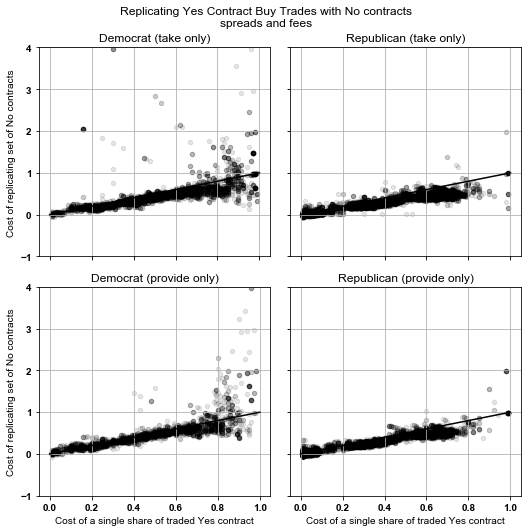

In [16]:
fig = plt.figure(figsize=(7.5, 7.5))

ax3 = plt.subplot(223)

dem_trader_analysis3_yes_provide.plot.scatter(x=('_trades', 'price_per_share'),
                                              y=('replication', 'max_loss'),
                                              alpha=0.1, ax=ax3, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.suptitle("Replicating Yes Contract Buy Trades with No contracts\nspreads and fees")
plt.title("Democrat (provide only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax4 = plt.subplot(224)

rep_trader_analysis3_yes_provide.plot.scatter(x=('_trades', 'price_per_share'),
                                              y=('replication', 'max_loss'),
                                              alpha=0.1, ax=ax4, sharey=ax3, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (provide only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax1 = plt.subplot(221)

dem_trader_analysis3_yes_take.plot.scatter(x=('_trades', 'price_per_share'),
                                           y=('replication', 'max_loss'),
                                           alpha=0.1, ax=ax1, sharex=ax3, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Democrat (take only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

ax2 = plt.subplot(222)

rep_trader_analysis3_yes_take.plot.scatter(x=('_trades', 'price_per_share'),
                                           y=('replication', 'max_loss'),
                                           alpha=0.1, ax=ax2, sharey=ax1, sharex=ax4, color='k')
plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (take only)")
plt.ylabel("Cost of replicating set of No contracts")
plt.xlabel("Cost of a single share of traded Yes contract")
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.95))

plt.savefig('charts/all_yes_yes_spread_yes_fees.png', dpi=300)

The next chart is for Figure 8.

In [17]:
dem_trader_analysis3_no_take = dem_trader_analysis3_no[
    dem_trader_analysis3_no.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

dem_trader_analysis3_no_provide = dem_trader_analysis3_no[
    dem_trader_analysis3_no.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

rep_trader_analysis3_no_take = rep_trader_analysis3_no[
    rep_trader_analysis3_no.loc[idx[:, ('_trades', 'take_provide')]] == 'T']

rep_trader_analysis3_no_provide = rep_trader_analysis3_no[
    rep_trader_analysis3_no.loc[idx[:, ('_trades', 'take_provide')]] == 'P']

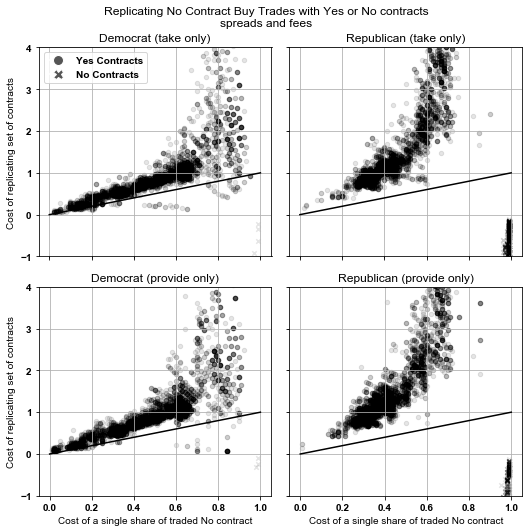

In [18]:
def yes_or_no(d_dict):
    return eval(d_dict)['contracts'] == 'YES'

fig = plt.figure(figsize=(7.5, 7.5))

ax3 = plt.subplot(223)

dem_trader_analysis3_no_provide[dem_trader_analysis3_no_provide[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax3, color='k')
dem_trader_analysis3_no_provide[~dem_trader_analysis3_no_provide[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax3, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.suptitle("Replicating No Contract Buy Trades with Yes or No contracts\nspreads and fees")
plt.title("Democrat (provide only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.grid(True)

ax4 = plt.subplot(224)

rep_trader_analysis3_no_provide[rep_trader_analysis3_no_provide[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax4, sharey=ax3, color='k')
rep_trader_analysis3_no_provide[~rep_trader_analysis3_no_provide[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax4, sharey=ax3, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (provide only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.grid(True)

ax1 = plt.subplot(221)

dem_trader_analysis3_no_take[dem_trader_analysis3_no_take[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax1, sharex=ax3, color='k')
dem_trader_analysis3_no_take[~dem_trader_analysis3_no_take[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax1, sharex=ax3, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Democrat (take only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.legend(handles=legend_elements)
plt.grid(True)

ax2 = plt.subplot(222)

rep_trader_analysis3_no_take[rep_trader_analysis3_no_take[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    alpha=0.1, ax=ax2, sharey=ax1, sharex=ax4, color='k')
rep_trader_analysis3_no_take[~rep_trader_analysis3_no_take[('replication', 'd')].apply(yes_or_no)].plot.scatter(
    x=('_trades', 'price_per_share'),
    y=('replication', 'max_loss'),
    marker='x',
    alpha=0.1, ax=ax2, sharey=ax1, sharex=ax4, color='k')

plt.ylim([-1, 4])
plt.plot([0, 1], [0, 1], c='k')
plt.title("Republican (take only)")
plt.ylabel("Cost of replicating set of contracts")
plt.xlabel("Cost of a single share of traded No contract")
plt.grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.95))

plt.savefig('charts/all_no_yes_spread_yes_fees.png', dpi=300)